#**Forecast Bike Sharing Demand**


# Problem Definition
Predict **the total count of bikes** rented **during each hour** covered by the test set, using only information available prior to the rental period

# Import the libraries

In [ ]:
# Python
import math, time, random, datetime
from IPython.display import HTML
from functools import reduce

# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('white')
import missingno as msno
colormap = plt.cm.RdBu
colors = ['tomato','teal','darkred','darkolivegreen','darkorange','darkslategray', 'darkgoldenrod','maroon','seagreen','cadetblue']

# Data Prep
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, Normalizer, MinMaxScaler, RobustScaler

# Model Training
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,StackingRegressor,VotingRegressor
from xgboost.sklearn import XGBRegressor

#Model Evaluation
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, GridSearchCV , KFold , StratifiedKFold

# Warning Control
import warnings
warnings.filterwarnings('ignore')

# Part 1: Importing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "drive/My Drive/Colab Notebooks/data/kaggle/bike-sharing"

In [ ]:
path = "drive/My Drive/Colab Notebooks/data/kaggle/bike-sharing/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

# Part 2: Exploratory Data Analysis 


Exploratory data analysis method is either non-graphical or graphical. Each method is either univariate or multivariate.

### Dimensions of Dataset

In [ ]:
train.shape

(10886, 12)

In [ ]:
test.shape

(6493, 9)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


At a glance, there are no missing values 

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


We do not have casual, registered (whether a renter is casual or registered user) and count (the target feature)

In [ ]:
train_nunique = train.nunique()
train_nunique

datetime      10886
season            4
holiday           2
workingday        2
weather           4
temp             49
atemp            60
humidity         89
windspeed        28
casual          309
registered      731
count           822
dtype: int64

In [ ]:
test_nunique = test.nunique()
test_nunique

datetime      6493
season           4
holiday          2
workingday       2
weather          4
temp            49
atemp           65
humidity        79
windspeed       27
dtype: int64

```
- independent features -
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
- target features -
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals
```

###Target Distribution

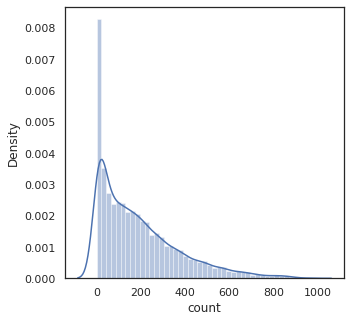

In [ ]:
plt.figure(figsize=(5, 5))
sns.distplot(train['count'])

### Univariate non-graphical EDA

The usual goal of univariate non-graphical EDA is to better understand the “sample distribution”  and also to make some preliminary conclusions.

#### Statistical Summary

In [ ]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


### Qualitative vs Quantitative Data Types

### Types of Data Variables

In [ ]:
dfnum = train.select_dtypes(include=['float64','int64'])
dfcat= train.select_dtypes(include=[object])
dftime = train.select_dtypes(include=['datetime64','timedelta64'])

### Numerical or Quantitative Data Variables
- Histogram, Pairplots, Correlation


###Univariate Plots
Used to better understand each attribute

#### Density Plots
Density plots are another way of getting a quick idea of the distribution of each attribute.  We can see the distribution for each attribute is clearer than the histograms.

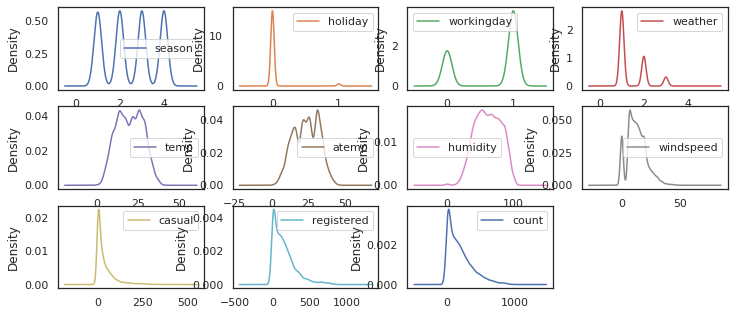

In [ ]:
train.plot(kind='density', subplots=True, layout=(4,4), sharex=False,figsize=(12,7))
plt.show()

#### Box and Whisker Plots
Boxplots summarize the distribution of each attribute, drawing a line for the median, the 25th and 75th percentiles. The whiskers give an idea of the spread of the data and dots outside of the whiskers
show **outlier values**.

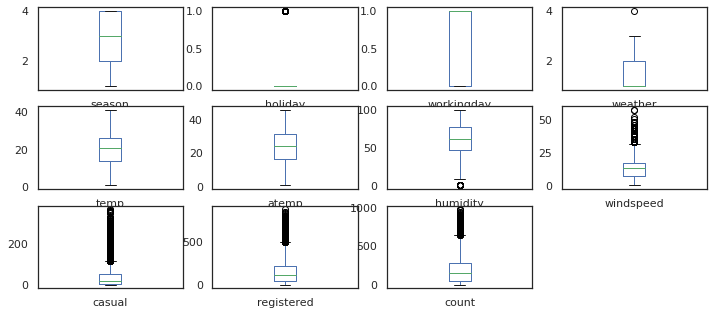

In [ ]:
train.plot(kind='box', subplots=True, layout=(4,4), sharex=False,figsize=(12,7))
plt.show()

###Multivariate Plots
Used to better understand the relationships between attributes.

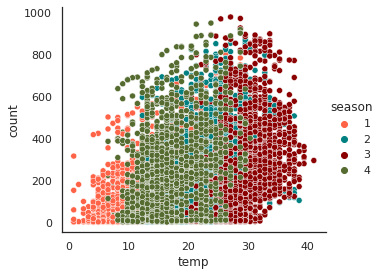

In [ ]:
sns.relplot(data=train, x='temp', y='count', kind='scatter', height=4, aspect=1.2, hue='season', palette=colors[:len(train.season.value_counts())] )

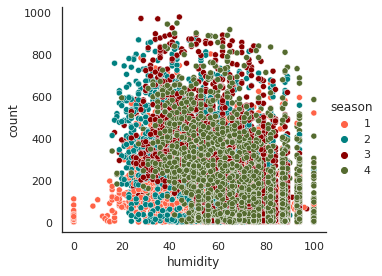

In [ ]:
sns.relplot(data=train, x='humidity', y='count', kind='scatter', height=4, aspect=1.2, hue='season', palette=colors[:len(train.season.value_counts())] )

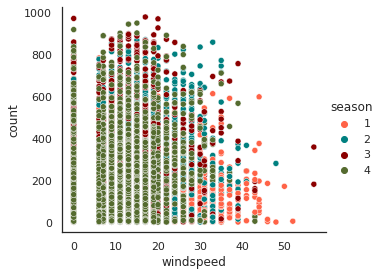

In [ ]:
sns.relplot(data=train, x='windspeed', y='count', kind='scatter', height=4, aspect=1.2, hue='season', palette=colors[:len(train.season.value_counts())] )

#### Correlation
Correlation gives an indication of how related the changes are between two variables. If two
variables change in the same direction they are positively correlated.

In [ ]:
print(dfnum.corr())

              season   holiday  workingday  ...    casual  registered     count
season      1.000000  0.029368   -0.008126  ...  0.096758    0.164011  0.163439
holiday     0.029368  1.000000   -0.250491  ...  0.043799   -0.020956 -0.005393
workingday -0.008126 -0.250491    1.000000  ... -0.319111    0.119460  0.011594
weather     0.008879 -0.007074    0.033772  ... -0.135918   -0.109340 -0.128655
temp        0.258689  0.000295    0.029966  ...  0.467097    0.318571  0.394454
atemp       0.264744 -0.005215    0.024660  ...  0.462067    0.314635  0.389784
humidity    0.190610  0.001929   -0.010880  ... -0.348187   -0.265458 -0.317371
windspeed  -0.147121  0.008409    0.013373  ...  0.092276    0.091052  0.101369
casual      0.096758  0.043799   -0.319111  ...  1.000000    0.497250  0.690414
registered  0.164011 -0.020956    0.119460  ...  0.497250    1.000000  0.970948
count       0.163439 -0.005393    0.011594  ...  0.690414    0.970948  1.000000

[11 rows x 11 columns]


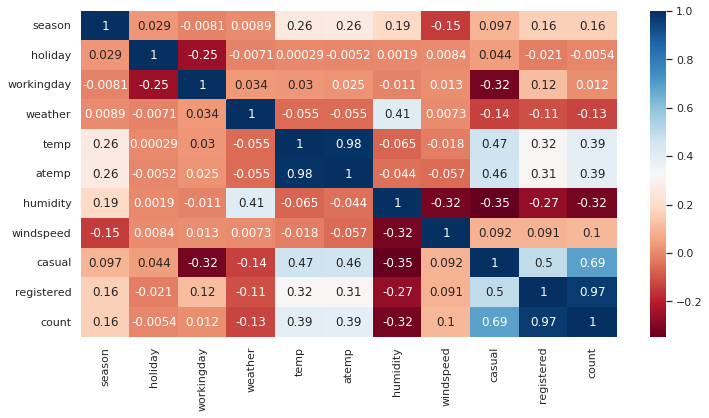

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), annot=True, cmap=colormap)

### Categorical or Qualitative Data Variables

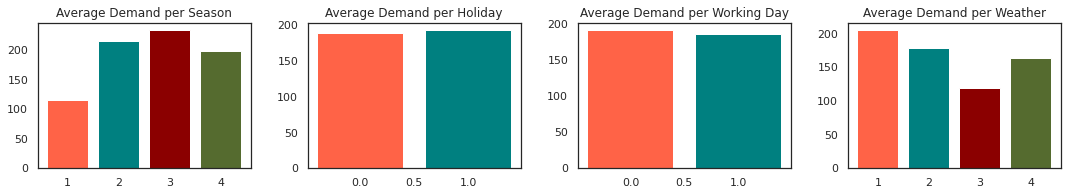

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(4,4,1)
plt.title('Average Demand per Season')
cat_list = train['season'].unique()
cat_average = train.groupby('season').mean()['count']
plt.bar(cat_list, cat_average, color=colors)

plt.subplot(4,4,2)
plt.title('Average Demand per Holiday')
cat_list = train['workingday'].unique()
cat_average = train.groupby('workingday').mean()['count']
plt.bar(cat_list, cat_average, color=colors)

plt.subplot(4,4,3)
plt.title('Average Demand per Working Day')
cat_list = train['holiday'].unique()
cat_average = train.groupby('holiday').mean()['count']
plt.bar(cat_list, cat_average, color=colors)

plt.subplot(4,4,4)
plt.title('Average Demand per Weather')
cat_list = train['weather'].unique()
cat_average = train.groupby('weather').mean()['count']
plt.bar(cat_list, cat_average, color=colors)


plt.tight_layout()

- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 


Violin Plot  
A better visualization might be the viloinplot(). It gives the categories and also the Kernel Density Curve of other numerical variable within each category.

<Figure size 360x288 with 0 Axes>

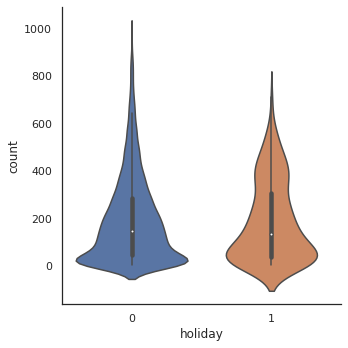

In [ ]:
plt.figure(figsize=(5,4))
sns.catplot(x="holiday", y = "count", kind = "violin", data=train)
plt.show()

<Figure size 360x288 with 0 Axes>

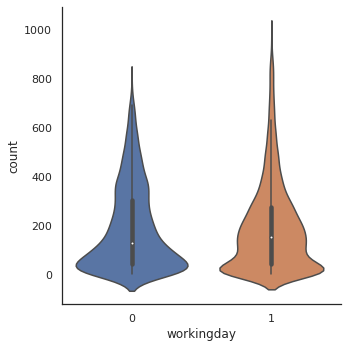

In [ ]:
plt.figure(figsize=(5,4))
sns.catplot(x="workingday", y = "count", kind = "violin", data=train)
plt.show()

#Part 3: Data Preparation

##Data Quality Assessment

###Inconsistent values

The below code shows the data type and values of each column. Review columns and see if the data type matches the column values.

In [ ]:
pd.DataFrame({"values":{col:train[col].unique() for col in train},'type':{col:train[col].dtype for col in train}})

,values,type
datetime,"[2011-01-01 00:00:00, 2011-01-01 01:00:00, 201...",object
season,"[1, 2, 3, 4]",int64
holiday,"[0, 1]",int64
workingday,"[0, 1]",int64
weather,"[1, 2, 3, 4]",int64
temp,"[9.84, 9.02, 8.2, 13.12, 15.58, 14.76, 17.22, ...",float64
atemp,"[14.395, 13.635, 12.88, 17.425, 19.695, 16.665...",float64
humidity,"[81, 80, 75, 86, 76, 77, 72, 82, 88, 87, 94, 1...",int64
windspeed,"[0.0, 6.0032, 16.9979, 19.0012, 19.9995, 12.99...",float64
casual,"[3, 8, 5, 0, 2, 1, 12, 26, 29, 47, 35, 40, 41,...",int64


###Duplicate Values

Check if there are duplicated rows.

In [ ]:
duplicate_rows_df = train[train.duplicated()]
duplicate_rows_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


There aren't any duplicated rows.

###Feature Value Range
Check min-max ranges for possible unusual values (such as negative values for Age or Fare etc...)

In [ ]:
for col in dfnum.columns:
  print(col, "Minimum", dfnum[col].min())

season Minimum 1
holiday Minimum 0
workingday Minimum 0
weather Minimum 1
temp Minimum 0.82
atemp Minimum 0.76
humidity Minimum 0
windspeed Minimum 0.0
casual Minimum 0
registered Minimum 0
count Minimum 1


In [ ]:
for col in dfnum.columns:
  print(col, "Maximum:", dfnum[col].max())

season Maximum: 4
holiday Maximum: 1
workingday Maximum: 1
weather Maximum: 4
temp Maximum: 41.0
atemp Maximum: 45.455
humidity Maximum: 100
windspeed Maximum: 56.9969
casual Maximum: 367
registered Maximum: 886
count Maximum: 977


### Outliers

The presence of outliers in a classification or regression dataset can result in a poor fit and lower predictive modeling performance. Regression models are more sensitive to Outliers

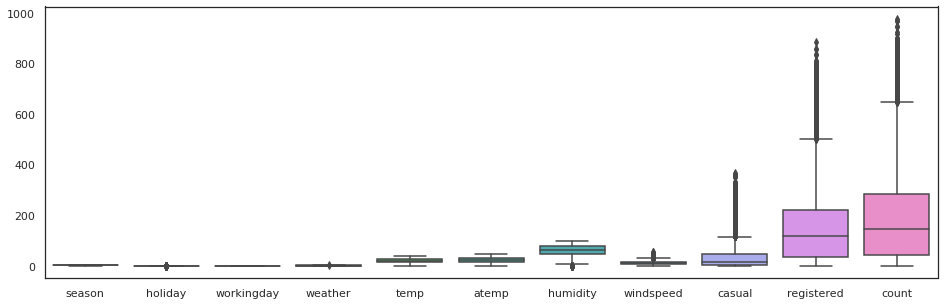

In [ ]:
plt.figure(figsize=(16,5))
sns.boxplot(data=dfnum)

In [ ]:
def remove_outliers(df, lower, upper):
  lower_range = df.quantile(lower)
  upper_range = df.quantile(upper)
  IQR = upper_range - lower_range
  df = df[~((df < (lower_range - 1.5 * IQR)) |(df > (upper_range + 1.5 * IQR))).any(axis=1)]
  return df

In [ ]:
train.shape

(10886, 12)

In [ ]:
train = remove_outliers(train, .1, .9)

In [ ]:
train.shape

(10447, 12)

Since high fare prices might be correlated with survival rate, deleting high outliers might affect the model performance.

##Data Cleaning

###Missing Data

In [ ]:
def check_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent missing'])

In [ ]:
check_missing(train) #percentage of missing value

,Total,Percent missing
count,0,0.0
registered,0,0.0
casual,0,0.0
windspeed,0,0.0
humidity,0,0.0
atemp,0,0.0
temp,0,0.0
weather,0,0.0
workingday,0,0.0
holiday,0,0.0


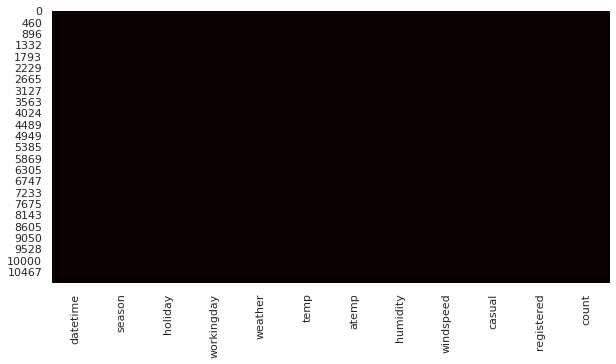

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(train.isnull(), cbar=False, cmap = "hot")

In [ ]:
check_missing(test) #percentage of missing value

,Total,Percent missing
windspeed,0,0.0
humidity,0,0.0
atemp,0,0.0
temp,0,0.0
weather,0,0.0
workingday,0,0.0
holiday,0,0.0
season,0,0.0
datetime,0,0.0


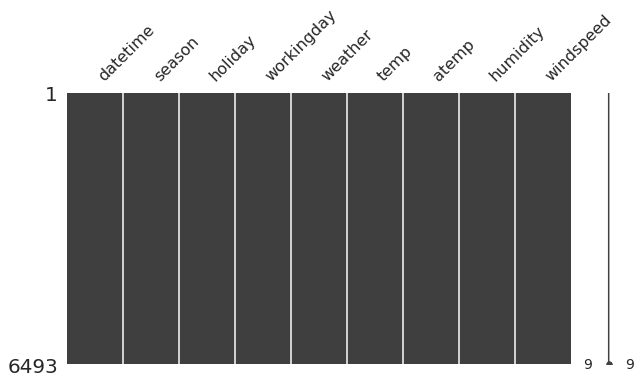

In [ ]:
#alternative way of vizulaizing missing values using msno library
msno.matrix(test, figsize = (10,5))

##Data Transformation

It is a good idea merge train and test data while performing feature engineering and encoding categorical variables. For instance, when encoding or binning, combining both the train and test data will guarantee all categories are encoded.

###Combine Train and Test Data
During data transformation, the train and test sets are usually combined to maintain consistency between them.

In [ ]:
train_copy = train.copy()
test_copy = test.copy()

In [ ]:
# set up a column to identify train and test set from the combined set
train_copy['Copy'] = 0
test_copy['Copy'] = 1

In [ ]:
bike_data = pd.concat([train_copy, test_copy], axis=0, copy=True)

In [ ]:
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Copy
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,0


### Feature Engineering

In [ ]:
# parse datetime column 
dt = pd.DatetimeIndex(bike_data['datetime'])
bike_data.set_index(dt, inplace=True)

####Datetime Features

In [ ]:
bike_data['date'] = dt.date
bike_data['day'] = dt.day
bike_data['month'] = dt.month
bike_data['year'] = dt.year
bike_data['hour'] = dt.hour
bike_data['dayweek'] = dt.dayofweek

In [ ]:
grouped_date_df = bike_data.groupby('date') 
grouped_day_df = bike_data.groupby('day')
grouped_month_df = bike_data.groupby('month')
grouped_year_df = bike_data.groupby('year')
grouped_hour_df = bike_data.groupby('hour')
grouped_dayweek_df = bike_data.groupby('dayweek')

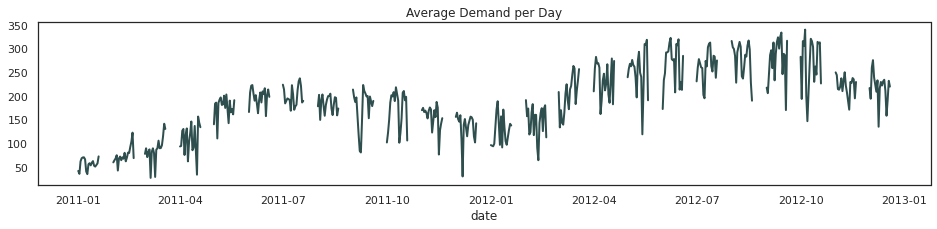

In [ ]:
grouped_date_df['count'].agg(np.mean).plot(linewidth=2,color='darkslategray',title ="Average Demand per Day", figsize=(16, 3));

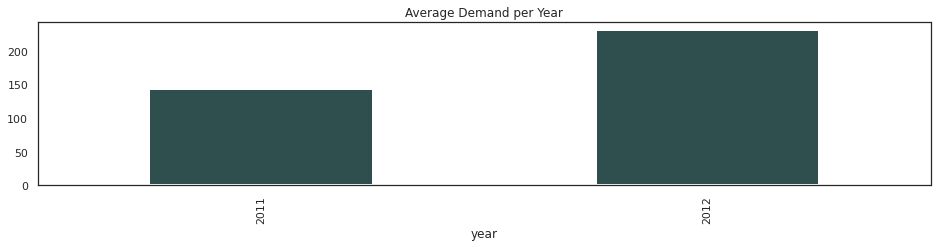

In [ ]:
grouped_year_df['count'].agg(np.mean).plot(kind='bar', linewidth=2,color='darkslategray',title ="Average Demand per Year", figsize=(16, 3));

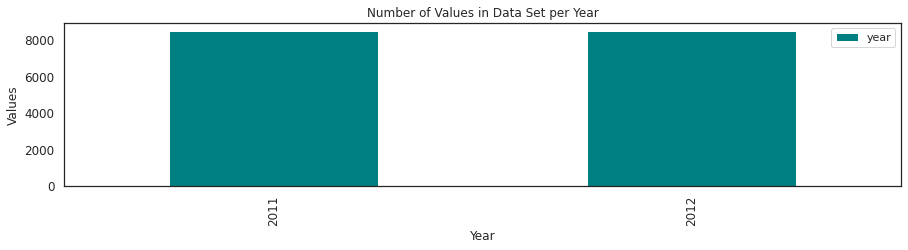

In [ ]:
plt.figure(figsize=(15,4))
values_df = bike_data['year'].value_counts().sort_index()
ax = plt.gca()
values_df.plot(kind='bar', title ="Number of Values in Data Set per Year", color='teal', figsize=(15, 3), legend=True, fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Values", fontsize=12)
plt.show()

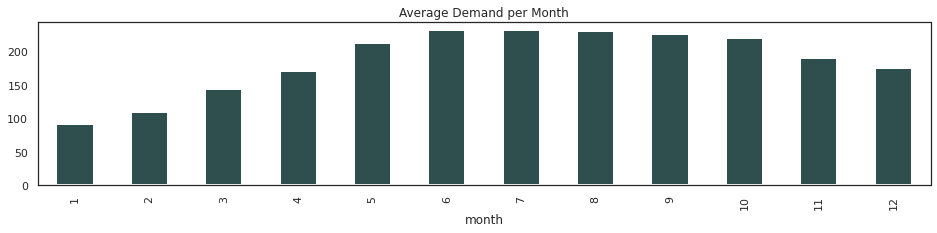

In [ ]:
grouped_month_df['count'].agg(np.mean).plot(kind='bar', linewidth=2,color='darkslategray',title ="Average Demand per Month", figsize=(16, 3));

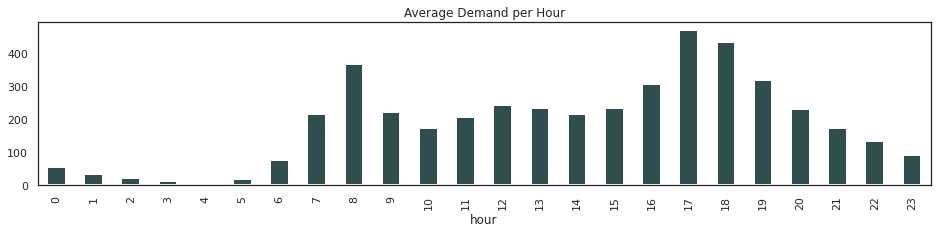

In [ ]:
grouped_hour_df['count'].agg(np.mean).plot(kind='bar', linewidth=2,color='darkslategray',title ="Average Demand per Hour", figsize=(16, 3));

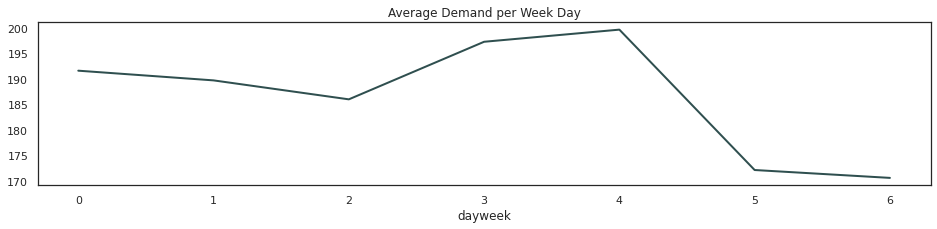

In [ ]:
grouped_dayweek_df['count'].agg(np.mean).plot(linewidth=2,color='darkslategray',title ="Average Demand per Week Day", figsize=(16, 3));

####Derived Variables

Derived Variables are generated by applying domain knowledge to come up with more meaningful features by extracting and utilizing parts of a column into new features.

In [ ]:
bike_data['worst_time'] = bike_data[['hour', 'workingday']]\
    .apply(lambda df: 1 if ((df['workingday'] == 1 and (df['hour'] == 8 or 17 <= df['hour'] <= 18)) \
                            or (df['workingday'] == 0 and 10 <= df['workingday'] <= 19)) else 0, axis = 1)

In [ ]:
bike_data['best_time'] = bike_data[['temp', 'windspeed']]\
    .apply(lambda df: 1 if (df['temp'] > 27 and df['windspeed'] < 30) else 0, axis = 1)

### Feature Scaling

When the data is comprised of attributes with varying scales, many machine learning algorithms
can benefit from rescaling the attributes to all have the same scale.



- Do this ONLY for Non-tree based models: Linear Models, Neural Networks, K-Nearest Neighbors, Support Vector Machines.<u> ***Tree based models don't require scaling.***</u>

Scaling data is applied based on the distribution of the data. Use the below function to check the distribution of a column before and after scaling.

### Scaling (Min-Max scaling)
Scale generally means to change the range of the values. The shape of the distribution doesn’t change
- Scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. 
- Scaling is important in the algorithms such as <u>support vector machines (SVM) and k-nearest neighbors (KNN)</u> where distance between the data points is important.

- Rescaling by the minimum and range of the vector, to make all the elements lie between 0 and 1 thus bringing all the values of numeric columns in the dataset to a common scale.   
- use when you do not know the distribution of your data 


$$X' = \frac{X-X_{mean}}{X_{max}-X_{min}}$$

In [ ]:
# Just a method to plot our fare distribution with some statistics
def show_distribution(Dist_Column):
    plt.figure()
    sns.kdeplot(Dist_Column, shade=True)
    plt.gcf().set_size_inches(15,2)
    plt.axvline(np.max(Dist_Column.values), color="Green", label ="Max")
    plt.axvline(np.min(Dist_Column.values), color="Yellow", label ="Min")
    plt.axvline(np.mean(Dist_Column.values)+np.std(Dist_Column.values), color="Orange", label ="Mean+Std")
    plt.axvline(np.mean(Dist_Column.values)-np.std(Dist_Column.values), color="Orange", label ="Mean-Std")
    plt.axvline(np.mean(Dist_Column.values), color="Red", label ="Mean")
    plt.axvline(np.median(Dist_Column.values), color="Black", label ="Median")
    plt.xlabel(Dist_Column.name)
    plt.ylabel("Density")
    plt.legend()
    return plt

In [ ]:
mm = MinMaxScaler() 

In [ ]:
scaled_cols = ['temp',	'atemp',	'humidity',	'windspeed',	'day',	'month',	'year',	'hour',	'dayweek',	'year',	'best_time']

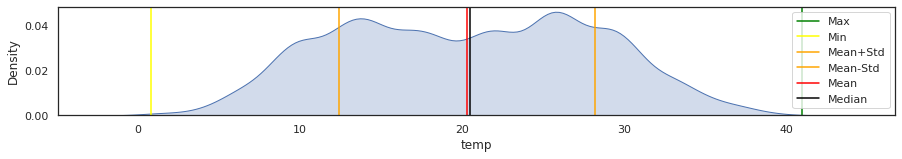

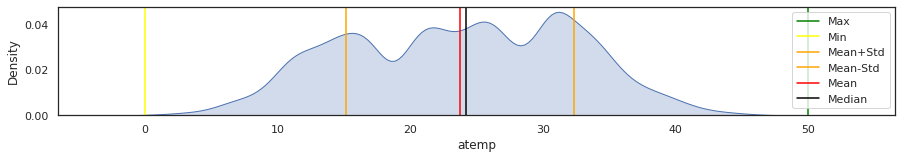

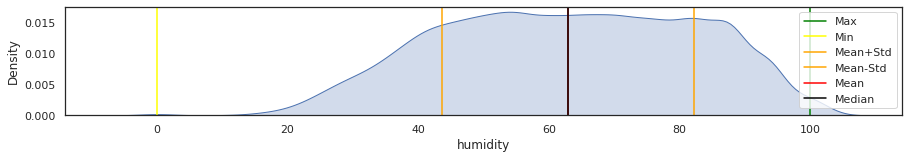

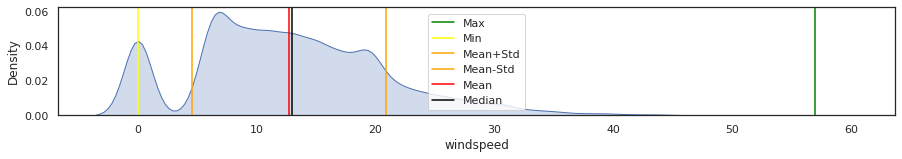

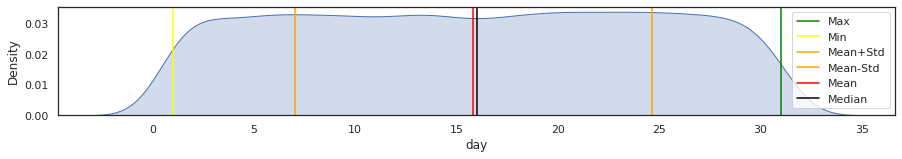

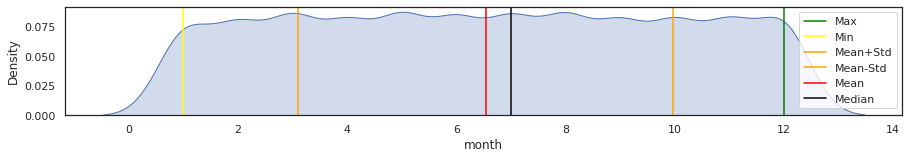

In [ ]:
for col in bike_data[scaled_cols[:6]].columns.tolist():
  show_distribution(bike_data[col])

In [ ]:
bike_scaled = bike_data.copy()

In [ ]:
for col in scaled_cols:
  bike_scaled[col] = mm.fit_transform(bike_scaled[col].values.reshape(-1,1))

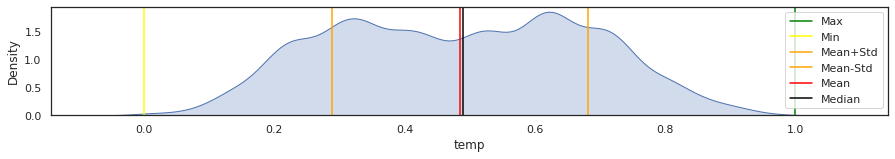

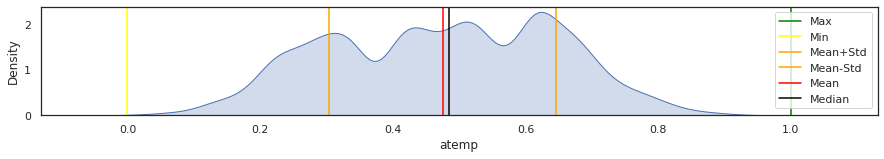

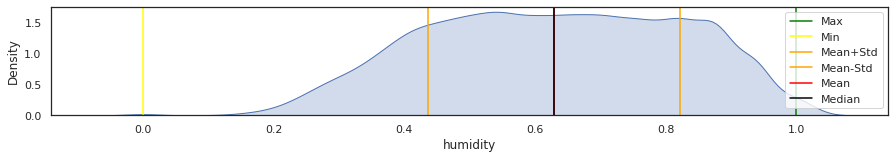

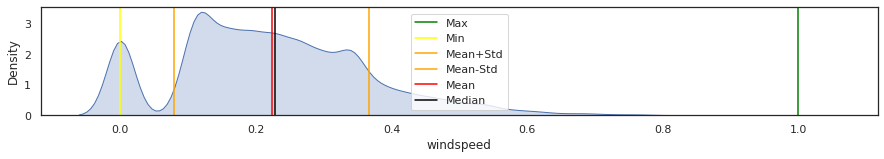

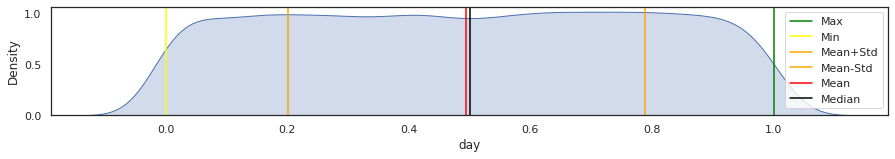

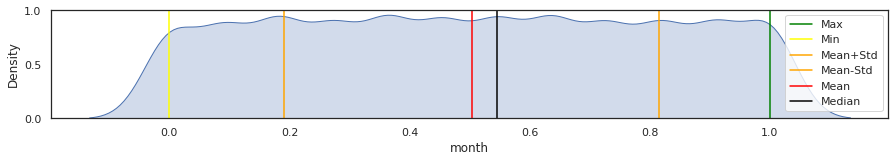

In [ ]:
for col in bike_scaled[scaled_cols[:6]].columns.tolist():
  show_distribution(bike_scaled[col])

###Feature Selection

In [ ]:
cor = bike_data.corr()
cor_target = abs(cor["count"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

season        0.164407
weather       0.125978
temp          0.381594
atemp         0.376493
humidity      0.301366
windspeed     0.100671
casual        0.675730
registered    0.978634
count         1.000000
month         0.167711
year          0.246955
hour          0.403260
worst_time    0.558247
best_time     0.272796
Name: count, dtype: float64

In [ ]:
selected_cols = ['season', 'weather',	'temp',	'atemp',	'humidity',	'windspeed', 'Copy', 'day',	'month',	'year',	'hour',	'dayweek', 'best_time']

In [ ]:
bike_selected = bike_data[selected_cols]

#Part 4: Model Training

###Split Train and Test Data

The test and train needs to be split prior to scaling and model training

In [ ]:
# split the data into training and testing data again
train = bike_data[bike_data['Copy']==0]
test= bike_data[bike_data['Copy']==1]

In [ ]:
dfs = (train, test)
for df in dfs:
  df.drop(['Copy'], axis = 1, inplace = True)

Normalized Data

In [ ]:
# split the data into training and testing data again
train_scaled = bike_scaled[bike_scaled['Copy']==0]
test_scaled = bike_scaled[bike_scaled['Copy']==1]

In [ ]:
dfs_scaled = (train_scaled, test_scaled)
for df in dfs_scaled:
  df.drop(['Copy'], axis = 1, inplace = True)

Selected Data

In [ ]:
# split the data into training and testing data again
train_selected = bike_selected[bike_selected['Copy']==0]
test_selected = bike_selected[bike_selected['Copy']==1]

In [ ]:
dfs_selected = (train_selected, test_selected)
for df in dfs_selected:
  df.drop(['Copy'], axis = 1, inplace = True)

##Separate Features and Target Variables

####Drop Features

Data that is not in test

In [ ]:
#columns not on test data
datetimecol = test["datetime"]
y_train = train["count"]
y_train_registered = train["registered"]
y_train_casual = train["casual"]

In [ ]:
dropFeatures = ['casual','count','registered','datetime','date']

In [ ]:
X_train  = train.drop(dropFeatures,axis=1)
X_test  = test.drop(dropFeatures,axis=1)

In [ ]:
X_train_scaled = train_scaled.drop(dropFeatures,axis=1)
X_test_scaled = test_scaled.drop(dropFeatures,axis=1)

In [ ]:
X_train_selected = train_selected
X_test_selected = test_selected

##Machine Learning Algorithms

In [ ]:
model_names = ['LinearRegression', 'Ridge', 'Lasso', 'RidgeCV', 'RandomForestRegressor', 'BaggingRegressor', 'GradientBoostingRegressor', 'AdaBoostRegressor', 'XGBRegressor']  

In [ ]:
regressions = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    RidgeCV(),
    RandomForestRegressor(n_estimators=100),
    BaggingRegressor(n_estimators=100),
    GradientBoostingRegressor(n_estimators=100,alpha=0.01),
    AdaBoostRegressor(n_estimators=100, random_state=0),
    XGBRegressor(n_estimators=100),]

Every model in Scikit-learn has a score method after being trained on X_train, y_train. Models have a score method providing a default evaluation criterion for the problem they are designed to solve. 

In [ ]:
def predict_models(names, models, X_train, y_train):

    y_preds = []
    for name, model in zip(names, models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train).tolist()
        y_preds.append(y_pred)
 
    pred_dict = dict(zip(names, y_preds))
    pred_dict = pd.DataFrame.from_dict(pred_dict)
    return pred_dict

In [ ]:
pred_dict = predict_models(model_names, regressions, X_train, y_train)
pred_dict_scaled = predict_models(model_names, regressions, X_train_scaled, y_train)
pred_dict_selected = predict_models(model_names, regressions, X_train_selected, y_train)

[07:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:42:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
pred_dict.head()

,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,-63.707706,-63.735683,-66.400624,-63.735682,20.72,20.56,25.426040,76.767361,24.813398
1,-60.124209,-60.150499,-62.875288,-60.150499,34.75,35.23,9.667711,76.767361,6.782959
2,-53.707279,-53.731919,-56.437220,-53.731919,28.37,28.65,4.337111,76.767361,-0.126650
3,-35.042383,-35.063200,-37.356545,-35.063200,12.27,12.54,3.006754,76.767361,-1.601502
4,-28.625453,-28.644620,-30.918477,-28.644620,2.18,1.75,-1.447829,76.767361,-1.601502


In [ ]:
pred_dict_scaled.head()

,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,-63.707706,-63.784874,-42.261107,-63.784874,22.99,20.17,25.426040,72.740458,24.813398
1,-60.124209,-60.250335,-38.976742,-60.250335,34.13,33.66,9.667711,69.089286,6.782959
2,-53.707279,-53.832155,-32.637742,-53.832155,27.94,28.19,4.337111,69.089286,-0.126650
3,-35.042383,-35.155153,-15.476430,-35.155153,12.48,13.04,3.006754,69.089286,-1.601502
4,-28.625453,-28.736974,-9.137430,-28.736974,2.77,2.48,-1.447829,69.089286,-1.601502


In [ ]:
pred_dict_selected.head()

,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,-86.008229,-85.991391,-82.614703,-85.840780,19.99,20.16,9.154444,77.500000,18.770201
1,-80.935507,-80.919067,-77.715708,-80.771998,34.61,35.67,-7.891522,74.006380,-2.015597
2,-73.141459,-73.125126,-69.971065,-72.979021,29.45,28.56,-16.380858,74.006380,-10.315425
3,-51.805184,-51.787973,-48.204121,-51.634021,12.17,12.13,-24.248342,79.668627,-18.383442
4,-44.011136,-43.994032,-40.459477,-43.841044,2.15,2.16,-24.248342,79.668627,-18.383442


The above negative prediction values result due to some of the data being out of the range of the regression. The data does not follow normal distribution in some cases. Data transformation(log(y) or 1/y, or other) will help.

In [ ]:
y_train_log = np.log1p(y_train)

In [ ]:
pred_dict_log = predict_models(model_names, regressions, X_train, y_train_log)
pred_dict_scaled_log = predict_models(model_names, regressions, X_train_scaled, y_train_log)
pred_dict_selected_log = predict_models(model_names, regressions, X_train_selected, y_train_log)

[07:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:43:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
pred_dict_log.head()

,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,2.281771,2.281680,3.077415,2.281680,3.076658,3.077480,3.166613,2.917148,3.290436
1,2.352275,2.352196,3.142359,2.352196,3.485317,3.450357,2.959367,2.503575,3.149993
2,2.444893,2.444821,3.222379,2.444821,3.230326,3.286317,2.479968,2.200336,2.681928
3,2.637992,2.637930,3.392914,2.637930,2.562706,2.470460,1.966866,1.960744,2.094973
4,2.730610,2.730555,3.472933,2.730555,0.903203,0.931923,1.049105,1.892515,1.091711


# Part 5: Model Evaluation Metrics 


##Evaluation
Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as

$$\sqrt{\frac{1}{n}\sum_{i=1}^n (log(p_i + 1) - log(a_i + 1))^2}$$

In [ ]:
def get_rmsle(y_train, y_pred):
    y_train_log = np.nan_to_num(np.array([np.log(i + 1) for i in y_train]))
    y_pred_log = np.nan_to_num(np.array([np.log(i + 1) for i in y_pred]))
    diff = (y_train_log - y_pred_log) ** 2
    return np.sqrt(np.mean(diff))

RMSLE is about percentage errors rather than absolute errors. RMSLE takes into account just the ratio of change. RMSLE penalizes under estimates more than over estimates. 

###Performance Metrics

In [ ]:
def get_metrics_values(models, y_test, pred_dict, metric_name):
  metrics_list = []
  for model in models:
    if metric_name == 'RMSLE':
      metric = mean_squared_log_error(y_test, pred_dict[model], squared=False)
    elif metric_name == 'RMSLE_formula':
      metric = get_rmsle(y_test, pred_dict[model])
    metrics_list.append(metric)
  
  metrics_dict = dict(zip(models, metrics_list))
  metrics_df = pd.DataFrame([metrics_dict])
  metrics_df['Evaluation'] = metric_name
  first_col = metrics_df.pop('Evaluation')
  metrics_df.insert(0, 'Evaluation', first_col)
  return metrics_df

#### RMSLE (sklearn)

In [ ]:
rmsle = get_metrics_values(model_names, y_train_log, pred_dict_log, metric_name = 'RMSLE')
rmsle

,Evaluation,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,RMSLE,0.221908,0.221912,0.248161,0.221912,0.031016,0.031487,0.096778,0.157845,0.09276


In [ ]:
rmsle_scaled = get_metrics_values(model_names, y_train_log, pred_dict_scaled_log, metric_name = 'RMSLE')
rmsle_scaled

,Evaluation,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,RMSLE,0.221908,0.221942,0.316154,0.221942,0.031655,0.031653,0.096778,0.159288,0.09276


In [ ]:
rmsle_selected = get_metrics_values(model_names, y_train_log, pred_dict_selected_log, metric_name = 'RMSLE')
rmsle_selected

,Evaluation,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,RMSLE,0.232756,0.232756,0.248161,0.232758,0.031378,0.031255,0.092152,0.149764,0.092719


#### RMSLE (math formula)

In [ ]:
RMSLE_formula = get_metrics_values(model_names, y_train_log, pred_dict_log, metric_name = 'RMSLE_formula')
RMSLE_formula


,Evaluation,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,RMSLE_formula,0.221908,0.221912,0.248161,0.221912,0.031016,0.031487,0.096778,0.157845,0.09276


In [ ]:
RMSLE_formula_scaled = get_metrics_values(model_names, y_train_log, pred_dict_scaled_log, metric_name = 'RMSLE_formula')
RMSLE_formula_scaled

,Evaluation,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,RMSLE_formula,0.221908,0.221942,0.316154,0.221942,0.031655,0.031653,0.096778,0.159288,0.09276


In [ ]:
RMSLE_formula_selected = get_metrics_values(model_names, y_train_log, pred_dict_selected_log, metric_name = 'RMSLE_formula')
RMSLE_formula_selected

,Evaluation,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,RMSLE_formula,0.232756,0.232756,0.248161,0.232758,0.031378,0.031255,0.092152,0.149764,0.092719


The results for scaled data is doesn't affect RMSLE. The sklearn and math RMSLE also generate the same results.

###Regression Metrics Analysis

In [ ]:
evaluation = pd.concat([rmsle]).T
evaluation_scaled = pd.concat([rmsle_scaled]).T
evaluation_selected = pd.concat([rmsle_selected]).T

In [ ]:
def get_evaluation_df(evaluation_df):
  evaluation_df.columns = evaluation_df.iloc[0].values.tolist()
  evaluation_df['Model'] = evaluation_df.index
  first_col = evaluation_df.pop('Model')
  evaluation_df.insert(0, 'Model', first_col)
  evaluation_df.reset_index(inplace=True)
  evaluation_df.drop(evaluation_df.index[evaluation_df['Model'] == 'Evaluation'], inplace=True)
  evaluation_df.drop('index', axis=1, inplace=True)
  evaluation_df.sort_values(by=['RMSLE'], ascending=True, inplace=True)
  return evaluation_df

In [ ]:
evaluation = get_evaluation_df(evaluation)
evaluation_scaled = get_evaluation_df(evaluation_scaled)
evaluation_selected = get_evaluation_df(evaluation_selected)

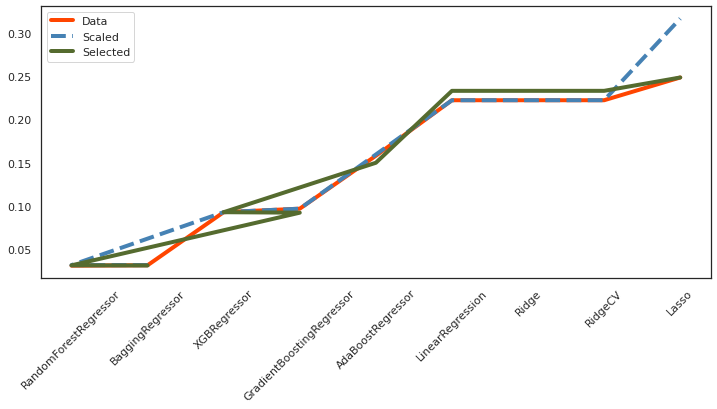

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(evaluation.Model,evaluation.RMSLE, color='orangered', linewidth=4, label="Data")
plt.plot(evaluation_scaled.Model, evaluation_scaled.RMSLE, color='steelblue', linewidth=4, label="Scaled", linestyle='dashed')
plt.plot(evaluation_selected.Model, evaluation_selected.RMSLE, color='darkolivegreen', linewidth=4, label="Selected")
plt.xticks(rotation = 45) # Rotates X-Axis 
plt.legend()
plt.show()

###Metrics Analysis Conclusions
The lower the RMSLE, the better a given model is able to fit the dataset. **RandomForestRegressor  and BaggingRegressor** are the best model based on RMSLE score.

##Hyperparameter Tuning

Hyperparameter tuning is the process of determining the right combination of hyperparameters that allows the model to maximize model performance. 

In [ ]:
def get_best_estimator(model, params):
  reg =  GridSearchCV(model, params, cv=5, return_train_score=False)
  reg.fit(X_train, y_train)
  return reg.best_estimator_

In [ ]:
br = BaggingRegressor()
br_params = {'n_estimators' : [100, 150, 200, 400, 500, 600, 1000], 'random_state': [0,5,10], 'n_jobs': [-1,0,1]}

In [ ]:
# best_br =  get_best_estimator(br, br_params)

In [ ]:
# best_br

In [ ]:
rfr = RandomForestRegressor()
rfr_params = {'n_estimators' : [100, 150, 200, 400, 500, 600, 1000], 'random_state': [1,2,3,4,5], 'min_samples_split': [1,2,3,4,5], 'max_depth': [1,2,3,4,5] }                

In [ ]:
# best_rfr =  get_best_estimator(rfr, rfr_params)

In [ ]:
# best_rfr

In [ ]:
br = BaggingRegressor(n_estimators = 200, n_jobs = -1, random_state = 10)

In [ ]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth=5, min_samples_split=3, random_state=3)

In [ ]:
vr = VotingRegressor([('bgr', br), ('rfr', rfr)])

In [ ]:
def get_final_rmsle (X, y):
  y_pred_rfr = rfr.fit(X, y).predict(X)
  y_pred_br = br.fit(X, y).predict(X)
  y_pred_vr = vr.fit(X, y).predict(X)

  final_rmsle_rfr = mean_squared_log_error(y, y_pred_rfr, squared=False)
  final_rmsle_br = mean_squared_log_error(y, y_pred_br, squared=False)
  final_rmsle_vr = mean_squared_log_error(y, y_pred_vr, squared=False)

  print('RandomForest:', final_rmsle_rfr, 'Bagging:', final_rmsle_br, 'Voting:', final_rmsle_vr)

In [ ]:
get_final_rmsle (X_train, y_train_log)

RandomForest: 0.12262848252613849 Bagging: 0.031425357575274857 Voting: 0.07530734044863828


In [ ]:
get_final_rmsle (X_train_scaled, y_train_log)

RandomForest: 0.12262764700692973 Bagging: 0.03144550688941135 Voting: 0.07533582486068606


In [ ]:
get_final_rmsle (X_train_selected, y_train_log)

RandomForest: 0.12415579057466493 Bagging: 0.03128608494006552 Voting: 0.07583895821394639


##Train Final Model

In [ ]:
br.fit(X_train, y_train_log).predict(X_train)   

array([3.09458798, 3.4433642 , 3.23702802, ..., 5.16393071, 4.90684183,
       4.52405643])

In [ ]:
best_predictor = br

In [ ]:
best_data = X_test

The RMSLE is higher than the log version as the ratio of difference between the y_train and y_pred values have changed but this is the best model and prediction.

# Part 10: Model Deployment

###Submission
In this case, deployment involves submitting data to Kaggle.

In [ ]:
predictions = best_predictor.predict(best_data)

In [ ]:
predictions

array([2.54486641, 1.86394655, 1.52726582, ..., 4.99672685, 4.69240097,
       4.14861236])

In [ ]:
#inverse of numpy's log1p()
final_predictions  = np.e**predictions

In [ ]:
final_predictions

array([ 12.74152587,   6.44913843,   4.60556712, ..., 147.92817461,
       109.11484663,  63.34603781])

In [ ]:
#create submission dataframe and get add the datetime column
submission = pd.DataFrame()
submission['datetime'] = datetimecol

In [ ]:
submission['count'] = final_predictions

In [ ]:
submission

,datetime,count
datetime,,
2011-01-20 00:00:00,2011-01-20 00:00:00,12.741526
2011-01-20 01:00:00,2011-01-20 01:00:00,6.449138
2011-01-20 02:00:00,2011-01-20 02:00:00,4.605567
2011-01-20 03:00:00,2011-01-20 03:00:00,3.951715
2011-01-20 04:00:00,2011-01-20 04:00:00,3.276127
...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,238.909387
2012-12-31 20:00:00,2012-12-31 20:00:00,187.554964
2012-12-31 21:00:00,2012-12-31 21:00:00,147.928175


In [ ]:
#make sure the number of rows for submission and test data matches
print(len(submission))
print(len(test))

6493
6493


In [ ]:
# Convert submisison dataframe to csv and save on Google Drive
timestr = time.strftime("%Y%m%d-%H%M%S")
submission.to_csv(path + timestr +"bike_kaggle_submission.csv", index=False, encoding='utf-8-sig')
print('Submission CSV saved on Drive')

Submission CSV saved on Drive
